## 시도명, 시군구명, 도로명 주소를 통해 카토그램 ID 필드 만들기

In [51]:
!apt-get install -y fonts-nanum > /dev/null
!fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib > /dev/null
# 런타임 다시시작

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/mnt')

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [3]:
data_folder = '/content/mnt/MyDrive/데이터/소상공인_상권'
data_folder2 = '/content/mnt/MyDrive/데이터/인구소멸위기지역'
result_dir = '/content/mnt/MyDrive/results/CoffeIndex'

In [4]:
starbucks = pd.read_csv(f'{result_dir}/스타벅스.csv')
coffebean = pd.read_csv(f'{result_dir}/커피빈.csv')
ediya = pd.read_csv(f'{result_dir}/이디야.csv')
paik = pd.read_csv(f'{result_dir}/빽다방.csv')

In [5]:
starbucks.시군구명.nunique(), coffebean.시군구명.nunique(), ediya.시군구명.nunique(), paik.시군구명.nunique()

(174, 87, 219, 152)

In [6]:
# 고성군 - 고성(강원), 고성(경남)
# 광역시 - 서울 용산, 서울 서대문, 대전 서구, 대전 유성
# 행정구 - 수원 장안, 용인 수지, 고양 일산동, 창원 합포, 창원 회원
tmp_gu_dict = {
    '수원':['장안구', '권선구', '팔달구', '영통구'], 
    '성남':['수정구', '중원구', '분당구'], 
    '안양':['만안구', '동안구'], 
    '안산':['상록구', '단원구'], 
    '고양':['덕양구', '일산동구', '일산서구'], 
    '용인':['처인구', '기흥구', '수지구'], 
    '청주':['상당구', '서원구', '흥덕구', '청원구'], 
    '천안':['동남구', '서북구'], 
    '전주':['완산구', '덕진구'], 
    '포항':['남구', '북구'], 
    '창원':['의창구', '성산구', '진해구', '마산합포구', '마산회원구']
}

In [7]:
starbucks[starbucks.시도명.str.contains('세종|제주')].head(12).tail()

,상호명,지점명,시도명,시군구명,도로명주소
344,스타벅스,세종첫마을점,세종특별자치시,세종특별자치시,세종특별자치시 세종특별자치시 한누리대로 169
345,스타벅스,NaN,세종특별자치시,세종특별자치시,세종특별자치시 세종특별자치시 도움5로 19
346,스타벅스,세종충남대학교병원점,세종특별자치시,세종특별자치시,세종특별자치시 세종특별자치시 보듬7로 20
935,스타벅스,제주송악산점,제주특별자치도,서귀포시,제주특별자치도 서귀포시 대정읍 형제해안로 322
936,스타벅스,성산일출봉점,제주특별자치도,서귀포시,제주특별자치도 서귀포시 성산읍 일출로 284-5


In [7]:
metro_list = ['서울특별시','부산광역시','대구광역시','인천광역시','대전광역시','광주광역시','울산광역시']

def get_ID(df):
  si_name = [None] * len(df)

  for i in df.index:
      if df.시도명[i] in metro_list:
          if len(df.시군구명[i]) == 2:
              si_name[i] = df.시도명[i][:2] + ' ' + df.시군구명[i]
          else:
              si_name[i] = df.시도명[i][:2] + ' ' + df.시군구명[i][:-1]     # 긴 구 이름에서 '구' 제외
      else:
        si_len = len(df.시군구명[i].split())
        if si_len == 1:
          if df.시군구명[i][:-1] == '고성':
            if df.시도명[i] == '강원도':
              si_name[i] = '고성(강원)'
            else:
              si_name[i] = '고성(경남)'
          elif df.시군구명[i][:-1] in tmp_gu_dict.keys():
            if len(df.도로명주소[i].split()[2]) == 5:
              si_name[i] = df.시군구명[i][:2] + ' ' + df.도로명주소[i].split()[2][2:-1]
            else:
              si_name[i] = df.시군구명[i][:2] + ' ' + df.도로명주소[i].split()[2][:-1]
          elif df.시군구명[i][:2] == '세종':
            si_name[i] = '세종'
          else:
            si_name[i] = df.시군구명[i][:-1]
        else:
          _, admingu = df.시군구명[i].split()
          for key, values in tmp_gu_dict.items():
              if admingu in values:
                  if len(admingu) == 2:
                      si_name[i] = key + ' ' + admingu
                  elif admingu in ['마산합포구', '마산회원구']:
                      si_name[i] = key + ' ' + admingu[2:-1]
                  else:
                      si_name[i] = key + ' ' + admingu[:-1]

  return  si_name

- 이디야를 기준으로 left join을 해서 계속 붙이면  240군데에 대해서는 값이 구해지고 나머지에서는 구해지지 않을것임

In [38]:
starbucks['ID'] = get_ID(starbucks)
ediya['ID'] = get_ID(ediya)
coffebean['ID'] = get_ID(coffebean)
paik['ID'] = get_ID(paik)

- 브랜드별 매장수

In [44]:
pt_sb = starbucks.pivot_table('상호명', index='ID', aggfunc='count')
pt_cb = coffebean.pivot_table('상호명', index='ID', aggfunc='count')
pt_ed = ediya.pivot_table('상호명', index='ID', aggfunc='count')
pt_bd = paik.pivot_table('상호명', index='ID', aggfunc='count')

In [45]:
pt_sb.columns = ['스타벅스']
pt_sb.reset_index(inplace=True)

pt_cb = coffebean.pivot_table('상호명', index='ID', aggfunc='count')
pt_cb.columns = ['커피빈']
pt_cb.reset_index(inplace=True)

pt_ed = ediya.pivot_table('상호명', index='ID', aggfunc='count')
pt_ed.columns = ['이디야']
pt_ed.reset_index(inplace=True)

pt_bd = paik.pivot_table('상호명', index='ID', aggfunc='count')
pt_bd.columns = ['빽다방']
pt_bd.reset_index(inplace=True)

In [46]:
cf = pd.merge(pt_ed, pt_sb, how='left')
len(cf)

236

In [47]:
cf = pd.merge(cf, pt_cb, how='left')
cf = pd.merge(cf, pt_bd, how='left')
cf.head()

,ID,이디야,스타벅스,커피빈,빽다방
0,가평,9,2.0,NaN,NaN
1,강릉,15,5.0,NaN,2.0
2,강진,1,NaN,NaN,NaN
3,거제,9,6.0,NaN,NaN
4,거창,1,NaN,NaN,1.0


In [48]:
cf.fillna(0, inplace=True)
cf.head()

,ID,이디야,스타벅스,커피빈,빽다방
0,가평,9,2.0,0.0,0.0
1,강릉,15,5.0,0.0,2.0
2,강진,1,0.0,0.0,0.0
3,거제,9,6.0,0.0,0.0
4,거창,1,0.0,0.0,1.0


In [49]:
cf['스타벅스'] = cf.스타벅스.astype(int)
cf['커피빈'] = cf.커피빈.astype(int)
cf['빽다방'] = cf.빽다방.astype(int)
cf.head()

,ID,이디야,스타벅스,커피빈,빽다방
0,가평,9,2,0,0
1,강릉,15,5,0,2
2,강진,1,0,0,0
3,거제,9,6,0,0
4,거창,1,0,0,1


In [50]:
cf['커피지수'] = (cf.스타벅스 + cf.커피빈) / (cf.이디야 + cf.빽다방)
cf.head()

,ID,이디야,스타벅스,커피빈,빽다방,커피지수
0,가평,9,2,0,0,0.222222
1,강릉,15,5,0,2,0.294118
2,강진,1,0,0,0,0.000000
3,거제,9,6,0,0,0.666667
4,거창,1,0,0,1,0.000000


In [51]:
cf.to_csv(f'{result_dir}/커피지수.csv', index=False)

In [18]:
!cp $data_folder2/draw_map.py .

In [52]:
from draw_map import BORDER_LINES, drawKorea, drawKoreaMinus

In [53]:
map_raw = pd.read_excel(f'{data_folder2}/draw_korea_raw(2021).xlsx')
map = pd.DataFrame(map_raw.stack())
map.reset_index(inplace=True)
print(map.shape)
map.head()

(250, 3)


,level_0,level_1,0
0,0,7,철원
1,0,8,화천
2,0,9,양구
3,0,10,고성(강원)
4,1,3,양주


In [54]:
map.columns = ['y','x','ID']
map.head()

,y,x,ID
0,0,7,철원
1,0,8,화천
2,0,9,양구
3,0,10,고성(강원)
4,1,3,양주


In [55]:
df = pd.merge(map, cf, how='left')
print(df.shape)
df.head()

(250, 8)


,y,x,ID,이디야,스타벅스,커피빈,빽다방,커피지수
0,0,7,철원,2.0,0.0,0.0,0.0,0.000000
1,0,8,화천,1.0,0.0,0.0,1.0,0.000000
2,0,9,양구,1.0,0.0,0.0,0.0,0.000000
3,0,10,고성(강원),NaN,NaN,NaN,NaN,NaN
4,1,3,양주,17.0,7.0,0.0,1.0,0.388889


In [56]:
df.fillna(0, inplace=True)
df['이디야'] = df.이디야.astype(int)
df['스타벅스'] = df.스타벅스.astype(int)
df['커피빈'] = df.커피빈.astype(int)
df['빽다방'] = df.빽다방.astype(int)
df.head()

,y,x,ID,이디야,스타벅스,커피빈,빽다방,커피지수
0,0,7,철원,2,0,0,0,0.000000
1,0,8,화천,1,0,0,1,0.000000
2,0,9,양구,1,0,0,0,0.000000
3,0,10,고성(강원),0,0,0,0,0.000000
4,1,3,양주,17,7,0,1,0.388889


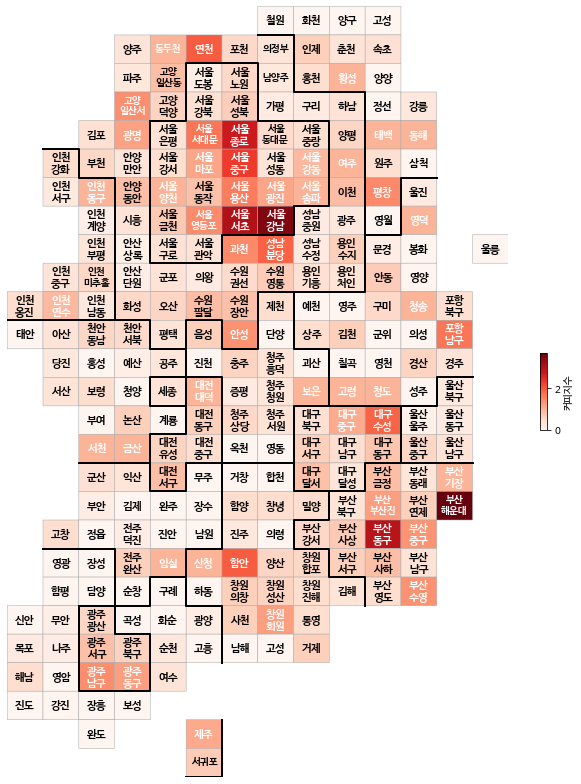

In [60]:
drawKorea('커피지수', df, 'Reds')